In [2]:
!pip install igor2

In [3]:
!pip install SciFiReaders

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import SciFiReaders
import glob
#from scipy.optimize import curve_fit

You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


In [5]:
ibw_file = "/home/shawn-patrick/Desktop/material1_perovksite/Image_10um_01.ibw"

In [6]:
reader = SciFiReaders.IgorIBWReader(ibw_file)
data = reader.read()

{'Channel_000': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: HeightRetrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_001': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: DeflectionRetrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_002': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: ZSensorRetrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,)}

<class 'sidpy.sid.dataset.Dataset'>


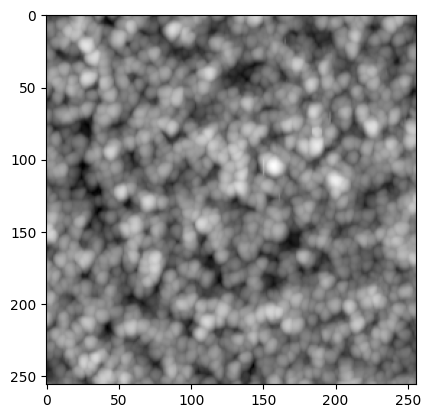

In [102]:
print(data)

height = data['Channel_000']

print('')
print(type(height))
img = np.array(height)

plt.imshow(img, cmap='gray')

# Segmenting normalised image

/home/shawn-patrick/anaconda3/envs/cellsam/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/shawn-patrick/anaconda3/envs/cellsam/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/shawn-patrick/anaconda3/envs/cellsam/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https

0.0 1.0


/home/shawn-patrick/Desktop/team-10/cellSAM/model.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cpu"))


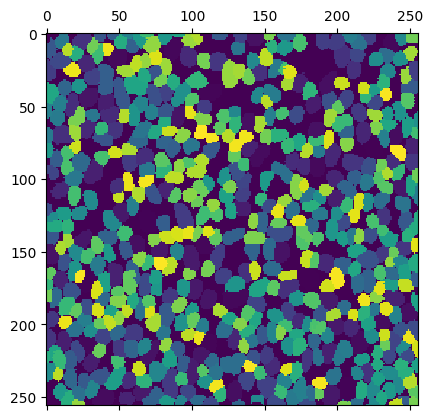

In [9]:
from cellSAM import segment_cellular_image

img = np.array(height)
img = (img-np.min(img))/np.ptp(img)
print(np.min(img), np.max(img))
mask, embedding, bounding_boxes = segment_cellular_image(img)
plt.matshow(mask)

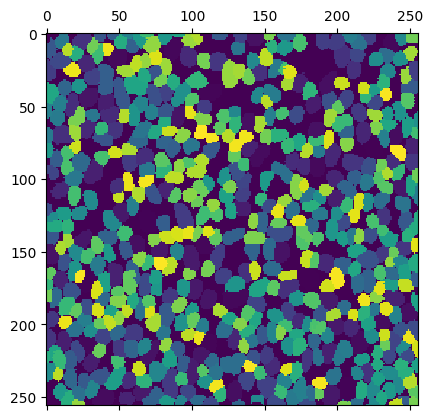

In [11]:
plt.matshow(mask)
plt.savefig("mask.png")

# Selecting samples from grains of different sizes

In [ ]:
from scipy.ndimage import center_of_mass

# Find the sizes of the different particles
sizes = np.zeros(np.max(mask)+1)

for ii in range(np.max(mask)+1):
    sizes[ii] = np.count_nonzero(mask==ii)

# Remove the zeroth element (the background)
sizes_new = sizes[1:]

# Bin these clusters by size
bins = 20
hist = np.histogram(sizes_new, bins=bins)
bin_boundaries = hist[1]

# Find the corresponding indices
size_args = []

for ii in range(bins):
    bounds = (bin_boundaries[ii], bin_boundaries[ii+1])
    bool_arr = np.array([sizes_new>=bounds[0], sizes_new<bounds[1]])
    size_args.append(list(np.argwhere(bool_arr.all(0)).T[0]))

# Take samples from each bin
no_of_samples = 3
sample_list = []

for ii in range(bins):
    #print(ii)
    if len(size_args[ii])>no_of_samples:
        sample_list.append(list(np.random.choice(size_args[ii], size=3, replace=False)))
    else:
        sample_list.append(size_args[ii])

# Find the pixel co-ordinates of these samples
coords = []

for ii in range(bins):
    sl = sample_list[ii]
    coord_ii = []
    for jj in range(len(sl)):
        mask_ii = mask==(ii+1) # +1 needed because we subtracted the zeroth element earlier
        coord_ii.append(center_of_mass(mask_ii))
    coords.append(coord_ii)




In [193]:
print(len(coords))

20


In [197]:
def size_filter(mask, bins, num_samples=1, setting='highest'):
    # Find the sizes of the different particles
    sizes = np.zeros(np.max(mask)+1)

    for ii in range(np.max(mask)+1):
        sizes[ii] = np.count_nonzero(mask==ii)

    # Remove the zeroth element (the background)
    sizes_new = sizes[1:]

    # Bin these clusters by size
    hist = np.histogram(sizes_new, bins=bins)
    bin_boundaries = hist[1]

    # Find the corresponding indices
    size_args = []

    for ii in range(bins):
        bounds = (bin_boundaries[ii], bin_boundaries[ii+1])
        bool_arr = np.array([sizes_new>=bounds[0], sizes_new<bounds[1]])
        size_args.append(list(np.argwhere(bool_arr.all(0)).T[0]))

    # Take samples from each bin
    sample_list = []

    for ii in range(bins):
        #print(ii)
        if len(size_args[ii])>num_samples:
            sample_list.append(list(np.random.choice(size_args[ii], size=num_samples, replace=False)))
        else:
            sample_list.append(size_args[ii])

    # Find the pixel co-ordinates of these samples
    coords = []

    if setting == 'highest':
        ii = 0
    if setting == 'lowest':
        ii = bins-1
       
    sl = sample_list[ii]

    coord_ii = []
    for jj in range(len(sl)):
        mask_ii = mask==(ii+1)
        coord_ii.append(center_of_mass(mask_ii))
    coords.append(coord_ii)

    

    return coords


In [198]:
size_filter(mask, 10, 1)

[[(np.float64(105.74324324324324), np.float64(158.78378378378378))]]

# Selecting areas with numerous grain boundaries (edges in the mask)

[[170. 200.]
 [160.  84.]
 [ 17.  74.]
 [139.  89.]
 [ 77. 131.]
 [198.  74.]
 [ 26. 131.]
 [105. 174.]
 [ 94. 104.]
 [156. 181.]
 [ 98.  89.]
 [159.  78.]
 [ 21.  65.]
 [ 82. 243.]
 [138.  94.]
 [ 31. 127.]
 [ 68. 107.]
 [199.  41.]
 [ 11.  73.]
 [ 28. 167.]
 [138. 100.]
 [198.  46.]
 [140.  83.]
 [130. 174.]
 [111.  63.]
 [ 17. 152.]
 [244. 117.]
 [ 25.  18.]
 [103.  69.]
 [173. 194.]
 [ 71. 126.]
 [ 58. 197.]
 [242. 188.]
 [173. 247.]
 [191.  53.]
 [ 12.  40.]
 [ 72. 137.]
 [193.  38.]
 [240. 250.]
 [  5. 100.]
 [121. 161.]
 [184.  50.]
 [185. 221.]
 [123. 211.]
 [ 96. 232.]
 [179. 228.]
 [207. 100.]
 [112. 103.]
 [116. 217.]
 [ 27. 136.]
 [ 82. 130.]
 [ 73. 193.]
 [ 61. 108.]
 [ 27.  57.]
 [190. 235.]
 [ 80. 180.]
 [121. 115.]
 [ 92.  95.]
 [ 71.  94.]
 [232.  64.]
 [197.  14.]
 [126. 160.]
 [177.  36.]
 [ 71. 131.]
 [ 59. 228.]
 [233. 167.]
 [ 22.  81.]
 [ 26.  62.]
 [191.  70.]
 [141. 177.]
 [ 88. 106.]
 [ 57.  55.]
 [  5.  73.]
 [ 40. 220.]
 [ 41. 233.]
 [ 33. 167.]
 [141. 143.]

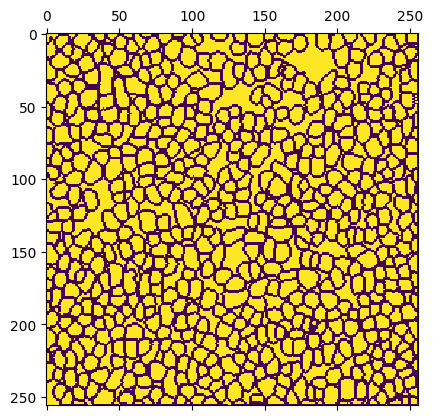

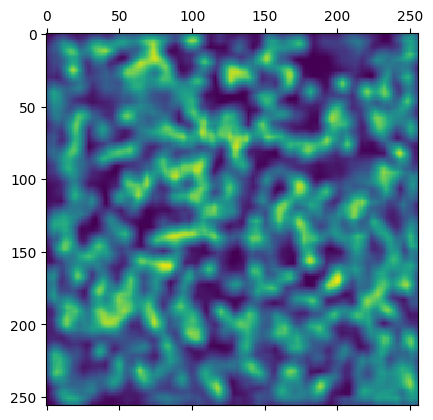

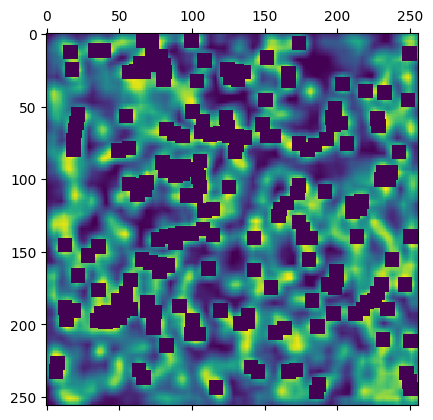

In [150]:
from scipy import signal

# Common edge detection method for grayscale images (perfect for this)
roll_up = np.roll(mask, 1, axis=0)
roll_down = np.roll(mask, -1, axis=0)
roll_left = np.roll(mask, 1, axis=1)
roll_right = np.roll(mask, -1, axis=1)

up = (mask==roll_up).astype(int)
down = (mask==roll_down).astype(int)
left = (mask==roll_left).astype(int)
right = (mask==roll_right).astype(int)

edges = up*down*left*right
plt.matshow(edges)

# Convolve kernel with edges to find regions with highest density of boundaries
ks = 10 # kernel size
kernel2d = np.ones((ks,ks))

boundary_density = signal.convolve2d(mask, kernel2d, mode='same', boundary='fill')
plt.matshow(boundary_density)

# Generate scan target coordinates
scan_size = 10
n_targets = 200


target_map = boundary_density.copy()

coords = np.zeros((n_targets, 2))

for ii in range(n_targets):
    coord = np.unravel_index(np.argmax(target_map), target_map.shape) # Find maximum density of boundaries in the current target map
    x_min = np.max((int(coord[1]-scan_size/2), 0))
    x_max = np.min((int(coord[1]+scan_size/2), target_map.shape[1]))
    y_min = np.max((int(coord[0]-scan_size/2), 0))
    y_max = np.min((int(coord[0]+scan_size/2), target_map.shape[1]))
    target_map[y_min:y_max, x_min:x_max] = 0 # Block out an area of scan_size**2 around to stop repeat imaging of the same region.

    coords[ii] = coord

print(coords)
plt.matshow(target_map)

In [30]:
len(np.unique(mask))

613

## Create Graph

0.49524984
175


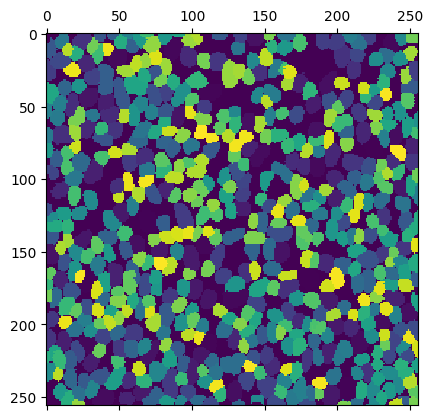

In [ ]:
test_mask = mask.copy()
test_img = img.copy()


boolean_mask = (test_mask == 3)



intensity = np.mean(img[boolean_mask])
print(intensity)

print(len(img[boolean_mask]))

plt.matshow(test_mask)

In [ ]:
centroids = []
intensities = []
labels = np.unique(mask)

temp_mask = mask.copy()

for unique_val in labels:

    label_indices = np.argwhere(test_mask == unique_val)

    #calculate centroids by averaging each individual grain
    centroid = np.array(np.uint8(np.mean(label_indices, axis=0)))
    centroids.append(centroid)

    #calculate the intensity of each grain
    boolean_mask = (test_mask == unique_val)
    intensity = np.mean(img[boolean_mask])
    intensities.append(intensity)
    
    
centroids = np.array(centroids)
intensities = np.array(intensities)

In [110]:
centroids

array([[116, 129],
       [105, 158],
       [ 93,  45],
       ...,
       [ 81, 242],
       [157,  77],
       [ 67, 106]], dtype=uint8)

In [ ]:
centroid

In [105]:
for x, y in centroids:
    img[x, y] = 0

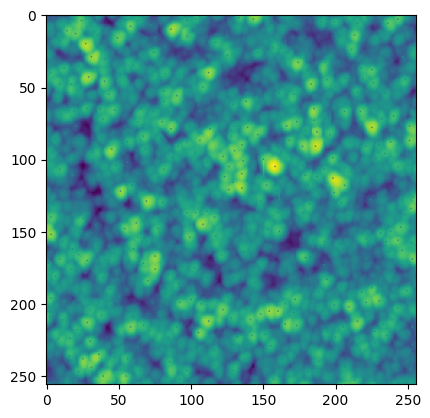

In [106]:
plt.imshow(img)

In [165]:
centroids.shape

(613, 2)

In [175]:
scaled_intensities= 255 * (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))

In [176]:
scaled_intensities

array([ 54.051155 , 252.67474  , 184.02348  , 116.15539  , 214.73189  ,
       189.26077  , 165.04842  , 125.43954  , 192.10623  , 215.89925  ,
       193.62355  , 215.11757  , 189.86633  , 177.57506  ,  84.92506  ,
       243.47554  , 177.55318  , 182.65013  , 210.56032  , 169.12314  ,
       158.76445  , 181.74957  , 120.58045  , 204.13199  , 142.84999  ,
       173.47447  , 148.90605  , 203.23592  , 196.59079  , 133.64107  ,
       130.3629   , 215.20827  , 202.751    , 189.26526  , 176.40314  ,
        73.9185   , 127.442635 , 151.95923  , 140.29706  ,  94.98141  ,
       189.46555  , 122.78638  , 120.96262  , 143.36713  , 160.14774  ,
       137.18085  , 118.76227  , 185.40143  , 255.00002  , 156.18831  ,
       222.37386  , 135.63565  , 173.84103  , 113.28219  , 123.442795 ,
       198.91525  , 116.310585 , 187.923    ,  91.762596 , 196.44547  ,
       196.31752  , 158.95892  , 157.9073   , 150.2476   , 160.40018  ,
       143.91035  , 237.89871  , 154.81871  , 178.86392  , 136.6

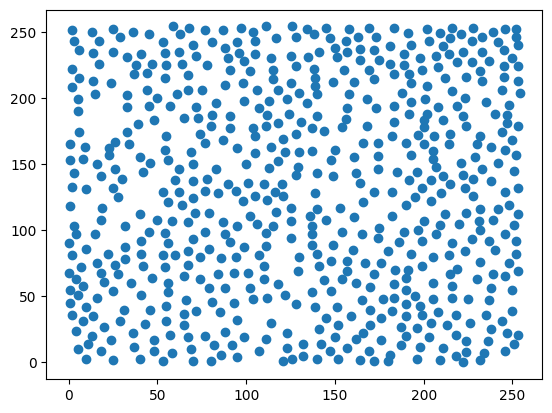

In [173]:
x, y = centroids[:, 0], centroids[: ,1]
plt.scatter(x, y)
plt.show()

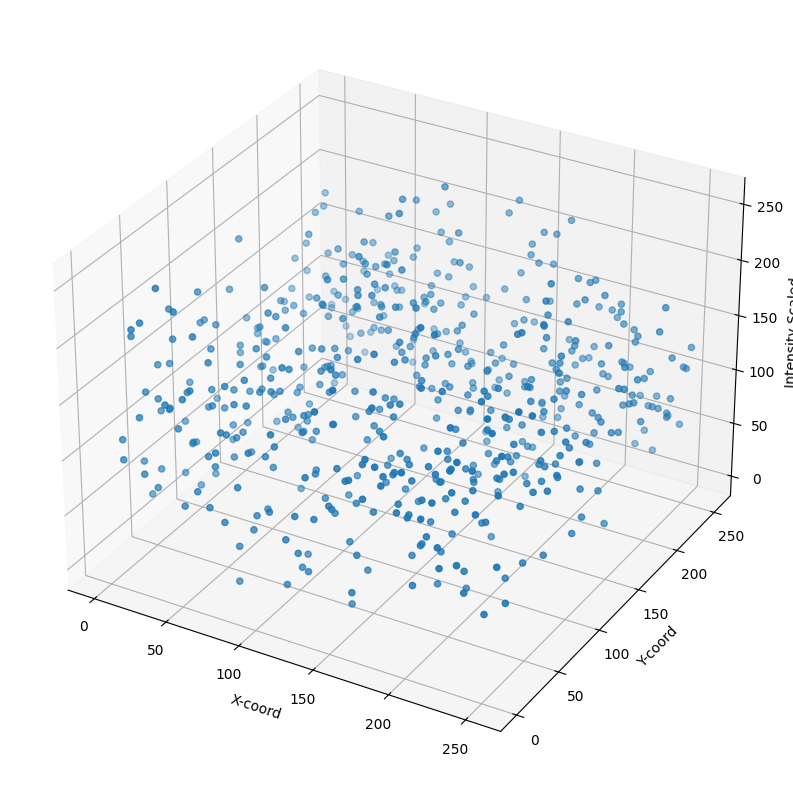

In [178]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, scaled_intensities)

ax.set_xlabel('X-coord')
ax.set_ylabel('Y-coord')
ax.set_zlabel('Intensity Scaled')
plt.show()